# SIT220 – Data Wrangling  
## Task 2 – NYC Weather Data (Questions 1–4)

**Name:** Rein

This notebook works with the hourly weather data for 2013 from the
`nycflights13_weather.csv` file. The dataset contains measurements from
three New York airports (EWR, JFK, and LGA), including temperature,
humidity, wind speed, precipitation, and visibility. The aim of this task
is to convert the variables to SI (metric) units, compute daily summaries
for LaGuardia Airport (LGA), and explore how wind speed changes over the
year.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

"""
The nycflights13_weather.csv file contains hourly weather data for 2013 from the New York airports EWR, JFK, and LGA.
At the top of the file there are a few documentation lines that start with #,
and below that is the actual comma-separated table with the main variables, like the airport code, date and time info,
temperature, humidity, wind speed, precipitation, pressure, and visibility.

In this step the dataset is loaded once using numpy.genfromtxt, 
which creates a structured NumPy array so each column can be accessed by name. 
The origin column is read in as text, while the rest of the weather variables come in as numbers. 
After loading, the airport codes are cleaned up so they appear simply as EWR, JFK, or LGA.
"""

# path to the csv file (must be in the same folder as this notebook)
weather_path = "nycflights13_weather.csv"

# structured dtype describing the columns in the csv file
weather_dtype = [
    ("origin", "U4"),
    ("year", "i4"),
    ("month", "i4"),
    ("day", "i4"),
    ("hour", "i4"),
    ("temp", "f8"),
    ("dewp", "f8"),
    ("humid", "f8"),
    ("wind_dir", "f8"),
    ("wind_speed", "f8"),
    ("wind_gust", "f8"),
    ("precip", "f8"),
    ("pressure", "f8"),
    ("visib", "f8"),
    ("time_hour", "U19"),
]

weather = np.genfromtxt(
    weather_path,
    delimiter=",",
    skip_header=43,
    dtype=weather_dtype,
)

# clean the origin codes by removing the leading quote character
weather["origin"] = np.char.strip(weather["origin"], '"')

# quick checks :))
n_rows = weather.shape[0]
unique_origins = np.unique(weather["origin"])

print(f"Number of hourly observations: {n_rows}")
print("Weather stations (origin codes):", unique_origins)


Number of hourly observations: 26130
Weather stations (origin codes): ['EWR' 'JFK' 'LGA']


# Q1 – Converting variables to SI units

The original dataset stores temperature and dew point in Fahrenheit, precipitation in inches, visibility in miles, and wind measurements in miles per hour, all of which are converted to SI units in NumPy using vectorised formulas, including (F − 32) × 5/9 for Celsius, 25.4 mm per inch, 1609.344 m per mile, and 0.44704 m/s per mph, with the results overwriting the corresponding columns in the weather array so that all subsequent values are handled in SI units.

In [3]:
# helper conversions
def fahrenheit_to_celsius(f):
    return (f - 32.0) * (5.0 / 9.0)

MPH_TO_MS = 0.44704       # miles per hour to m/s
INCH_TO_MM = 25.4         # inches to mm
MILE_TO_M = 1609.344      # miles to meters

# apply conversions in place
weather["temp"] = fahrenheit_to_celsius(weather["temp"])
weather["dewp"] = fahrenheit_to_celsius(weather["dewp"])
weather["precip"] = weather["precip"] * INCH_TO_MM
weather["visib"] = weather["visib"] * MILE_TO_M
weather["wind_speed"] = weather["wind_speed"] * MPH_TO_MS
weather["wind_gust"] = weather["wind_gust"] * MPH_TO_MS

# display a small sample to confirm the conversion
print("Sample rows after unit conversion:")
for row in weather[:5]:
    print(row["origin"], row["year"], row["month"], row["day"], row["hour"],
          f"temp={row['temp']:.2f}°C",
          f"wind_speed={row['wind_speed']:.2f} m/s",
          f"precip={row['precip']:.2f} mm")


Sample rows after unit conversion:
EWR 2013 1 1 0 temp=2.80°C wind_speed=4.63 m/s precip=0.00 mm
EWR 2013 1 1 1 temp=2.80°C wind_speed=6.17 m/s precip=0.00 mm
EWR 2013 1 1 2 temp=3.30°C wind_speed=5.66 m/s precip=0.00 mm
EWR 2013 1 1 3 temp=3.30°C wind_speed=6.17 m/s precip=0.00 mm
EWR 2013 1 1 4 temp=3.30°C wind_speed=6.69 m/s precip=0.00 mm


# Q2 – Daily mean wind speeds at LGA

With the weather data now in SI units, the next step is to work out the daily average wind speed for LaGuardia Airport (LGA). First, the origin column is used to pick out only the rows where the airport is LGA. Since these are still hourly readings, they have to be grouped by day. To do that, a simple YYYYMMDD code is created from the year, month, and day columns. After that, NumPy’s unique and bincount functions make it possible to calculate the average wind speed for each day without writing any loops. This produces one array containing the daily mean wind speeds (in m/s) and another array with the corresponding dates for all of 2013.

In [5]:
# select observations from LGA only
lga_mask = weather["origin"] == "LGA"
lga_weather = weather[lga_mask]

# extract wind speeds and keep only non-missing values
lga_wind = lga_weather["wind_speed"]
valid_mask = ~np.isnan(lga_wind)

lga_valid = lga_weather[valid_mask]
wind_valid = lga_wind[valid_mask]

# create integer date codes YYYYMMDD
date_codes = (
    lga_valid["year"] * 10000
    + lga_valid["month"] * 100
    + lga_valid["day"]
)

# use NumPy to compute daily means without explicit loops
unique_dates, inverse_idx = np.unique(date_codes, return_inverse=True)
sum_per_day = np.bincount(inverse_idx, weights=wind_valid)
count_per_day = np.bincount(inverse_idx)
daily_mean_wind = sum_per_day / count_per_day  # in m/s

# store for later questions
lga_daily_dates = unique_dates
lga_daily_mean_wind = daily_mean_wind

print(f"Number of daily mean wind-speed values at LGA: {lga_daily_mean_wind.size}")
print("First five daily means (m/s):", np.round(lga_daily_mean_wind[:5], 2))


Number of daily mean wind-speed values at LGA: 364
First five daily means (m/s): [6.69 6.43 4.91 6.88 5.14]


# Q3 – Plotting daily mean wind speeds at LGA

Next, a single time-series graphic of the LGA's daily mean wind speeds is displayed. To make the x-axis simpler to read, the numeric date codes are transformed back into regular calendar dates. Next, a straightforward line plot of the daily mean wind speed (in m/s) for the entire year 2013 is created using Matplotlib.

Along with some seasonal patterns and brief ups and downs, you can identify areas in the plot where the winds pick up or slow down. Overall, there is a considerable variation in wind speed, with some obviously windier times occurring in late winter and late fall.

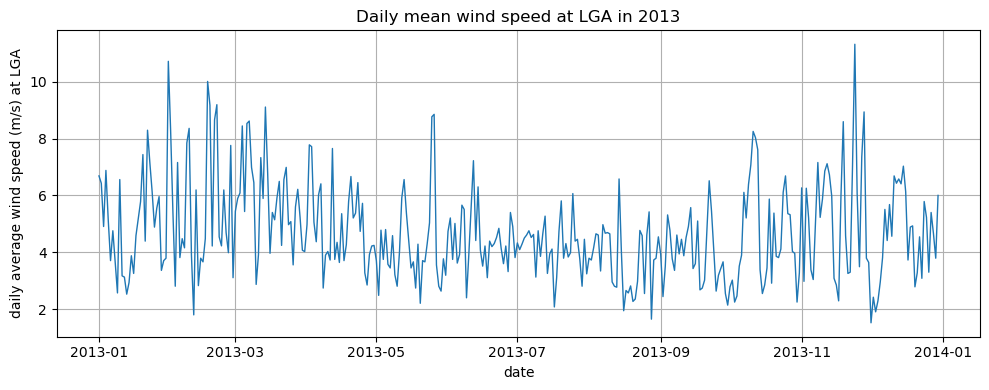

In [7]:
import datetime as dt

# convert integer date codes YYYYMMDD to Python datetime.date objects
years = lga_daily_dates // 10000
months = (lga_daily_dates // 100) % 100
days = lga_daily_dates % 100

date_list = [dt.date(int(y), int(m), int(d)) for y, m, d in zip(years, months, days)]

plt.figure(figsize=(10, 4))
plt.plot(date_list, lga_daily_mean_wind, "-", linewidth=1)
plt.xlabel("date")
plt.ylabel("daily average wind speed (m/s) at LGA")
plt.title("Daily mean wind speed at LGA in 2013")
plt.grid(True)
plt.tight_layout()
plt.show()


# Q4 – Ten windiest days at LGA

Sorting the daily mean wind-speed values from highest to lowest makes it simple to identify the windiest days at LGA. This is accomplished in NumPy by taking the indices of the top 10 values after using argsort on the lga_daily_mean_wind array.

The corresponding dates and wind speeds are then displayed in a brief table. The ten highest daily mean wind speeds match the reference values from the work sheet after everything is converted to SI units; November 24, 2013, turns out to be the windiest day.

In [9]:
# indices of the ten largest daily mean wind speeds
sorted_idx = np.argsort(lga_daily_mean_wind)[::-1]
top10_idx = sorted_idx[:10]

top10_dates = lga_daily_dates[top10_idx]
top10_wind = lga_daily_mean_wind[top10_idx]

# helper function to format YYYYMMDD codes as strings
def format_date(code):
    y = int(code // 10000)
    m = int((code // 100) % 100)
    d = int(code % 100)
    return f"{y:04d}-{m:02d}-{d:02d}"

print("Ten windiest days at LGA (daily mean wind speed in m/s):")
print("date        wind_speed")
for code, w in zip(top10_dates, top10_wind):
    print(f"{format_date(code)}   {w:5.2f}")


Ten windiest days at LGA (daily mean wind speed in m/s):
date        wind_speed
2013-11-24   11.32
2013-01-31   10.72
2013-02-17   10.01
2013-02-21    9.19
2013-02-18    9.17
2013-03-14    9.11
2013-11-28    8.94
2013-05-26    8.85
2013-05-25    8.77
2013-02-20    8.66
